# Section 4

In [139]:
# Import required packages
from IPython.display import clear_output
import random
from tqdm import tqdm
import joblib
import uuid 
import subprocess
import json
import anndata
import numpy as np
import pandas as pd
import scanpy as sc
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import KFold
from sklearn.linear_model import ElasticNet, ARDRegression
import dynamo as dyn
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib.patches as mpatches
import seaborn as sns
from upsetplot import from_contents
from scipy.stats import pearsonr
from scipy.stats import spearmanr
from scipy.stats import fisher_exact
histone_palette = { #Define a standard color for each histone mark
    'H3K27ac':sns.color_palette('colorblind')[0],
    'H3K9ac':sns.color_palette('colorblind')[1],
    'H3K4me3':sns.color_palette('colorblind')[2],
    'H3K4me1':sns.color_palette('colorblind')[3],
    'H3K9me3':sns.color_palette('colorblind')[4],
    'H3K27me3':sns.color_palette('colorblind')[5],
    'H3K36me3':sns.color_palette('colorblind')[6],
}
dyn.configuration.set_pub_style() # Define publication style quality for figures

In [145]:
# Load data
adata_genes_across_histones = sc.read_h5ad('../results/adata_genes_across_histones.h5ad')
adata_genes_across_histones_flipped = sc.read_h5ad('../results/adata_genes_across_histones_flipped.h5ad')
adata_genes_pan_histone = sc.read_h5ad('../results/adata_genes_pan_histone.h5ad')
adata_genes_across_activating_histone_group = sc.read_h5ad('../results/adata_genes_across_activating_histone_group.h5ad')
adata_genes_across_repressing_histone_group = sc.read_h5ad('../results/adata_genes_across_repressing_histone_group.h5ad')
adata_genes_primary_cells_untreated = sc.read_h5ad('../data/encode_data/adata_genes_primary_cells_untreated.h5ad')
adata_genes = sc.read_h5ad('../data/encode_data/adata_genes.h5ad')

In [146]:
# Define function to calculate the weight of each gene for each histone mark model
def get_gene_weights(histone, adata, protein_coding=False):

    feature_selector_path = '../results/models/' + histone + '_feature_selector.pkl'
    feature_selector = joblib.load(feature_selector_path)

    dim_reduction_path = '../results/models/' + histone + '_dim_reduction.pkl'
    dim_reduction = joblib.load(dim_reduction_path)

    model_path = '../results/models/' + histone + '_model.pkl'
    model = joblib.load(model_path)

    used_genes = np.array(adata.var_names)[feature_selector.coef_ != 0]
    gene_weights = dim_reduction.inverse_transform(model.coef_.reshape(1,-1))

    gene_weights_df = pd.DataFrame(np.concatenate([gene_weights, np.abs(gene_weights)]).T, index=used_genes, columns=['gene_weight', 'gene_weight_abs'])
    gene_df = pd.concat([adata.var, gene_weights_df], join='inner', axis=1).sort_values(by='gene_weight_abs', ascending=False)
    
    gene_df[gene_df == 'nan'] = np.nan
    
    if protein_coding:
        gene_df = gene_df[gene_df.gene_biotype == 'protein_coding']
    
    return gene_df

In [147]:
# Define function to do GSEA for the genes selected for each model
def get_panther_overrepresentation_df(histone, adata, top_n=20):
    
    genes = get_gene_weights(histone, adata).dropna(axis=0, subset=['gene_name']).index.tolist()
    gene_string = ','.join(genes)
    panther_db_url = "http://pantherdb.org/services/oai/pantherdb/enrich/overrep?geneInputList=" + gene_string + "&organism=9606&annotDataSet=GO%3A0008150&enrichmentTestType=FISHER&correction=FDR"
    
    subprocess.call("curl -X POST \"" + panther_db_url + "\" -H \"accept: application/json\" --output ../results/enrichment/" + histone + "_panther.json", shell=True)
    
    clear_output()
    
    with open('../results/enrichment/' + histone + '_panther.json', 'r') as f:
        panther_json = json.load(f)
        
    go_terms = []
    negative_log_p_values = []
    fold_enrichments = []
    for go_result in panther_json['results']['result']:
        try:
            go_term = go_result['term']['label'] + ' (' + go_result['term']['id'] + ')'
            negative_log_p_value = -np.log(go_result['pValue'])
            fold_enrichment = go_result['fold_enrichment']
        except:
            continue

        go_terms += [go_term]
        negative_log_p_values += [negative_log_p_value]
        fold_enrichments += [fold_enrichment]

    enrichment_df = pd.DataFrame(np.array([go_terms, negative_log_p_values, fold_enrichments]).T, columns=['go_term', 'negative_log_p_value', 'fold_enrichment'])
    enrichment_df['negative_log_p_value'] = enrichment_df['negative_log_p_value'].astype(float)
    enrichment_df['fold_enrichment'] = enrichment_df['fold_enrichment'].astype(float)
    
    return enrichment_df.iloc[0:top_n]

## Figure 4

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator ElasticNet from version 1.0.1 when using version 1.1.3. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator TruncatedSVD from version 1.0.1 when using version 1.1.3. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator ARDRegression from version 1.0.1 when using version 1.1.3. This mi

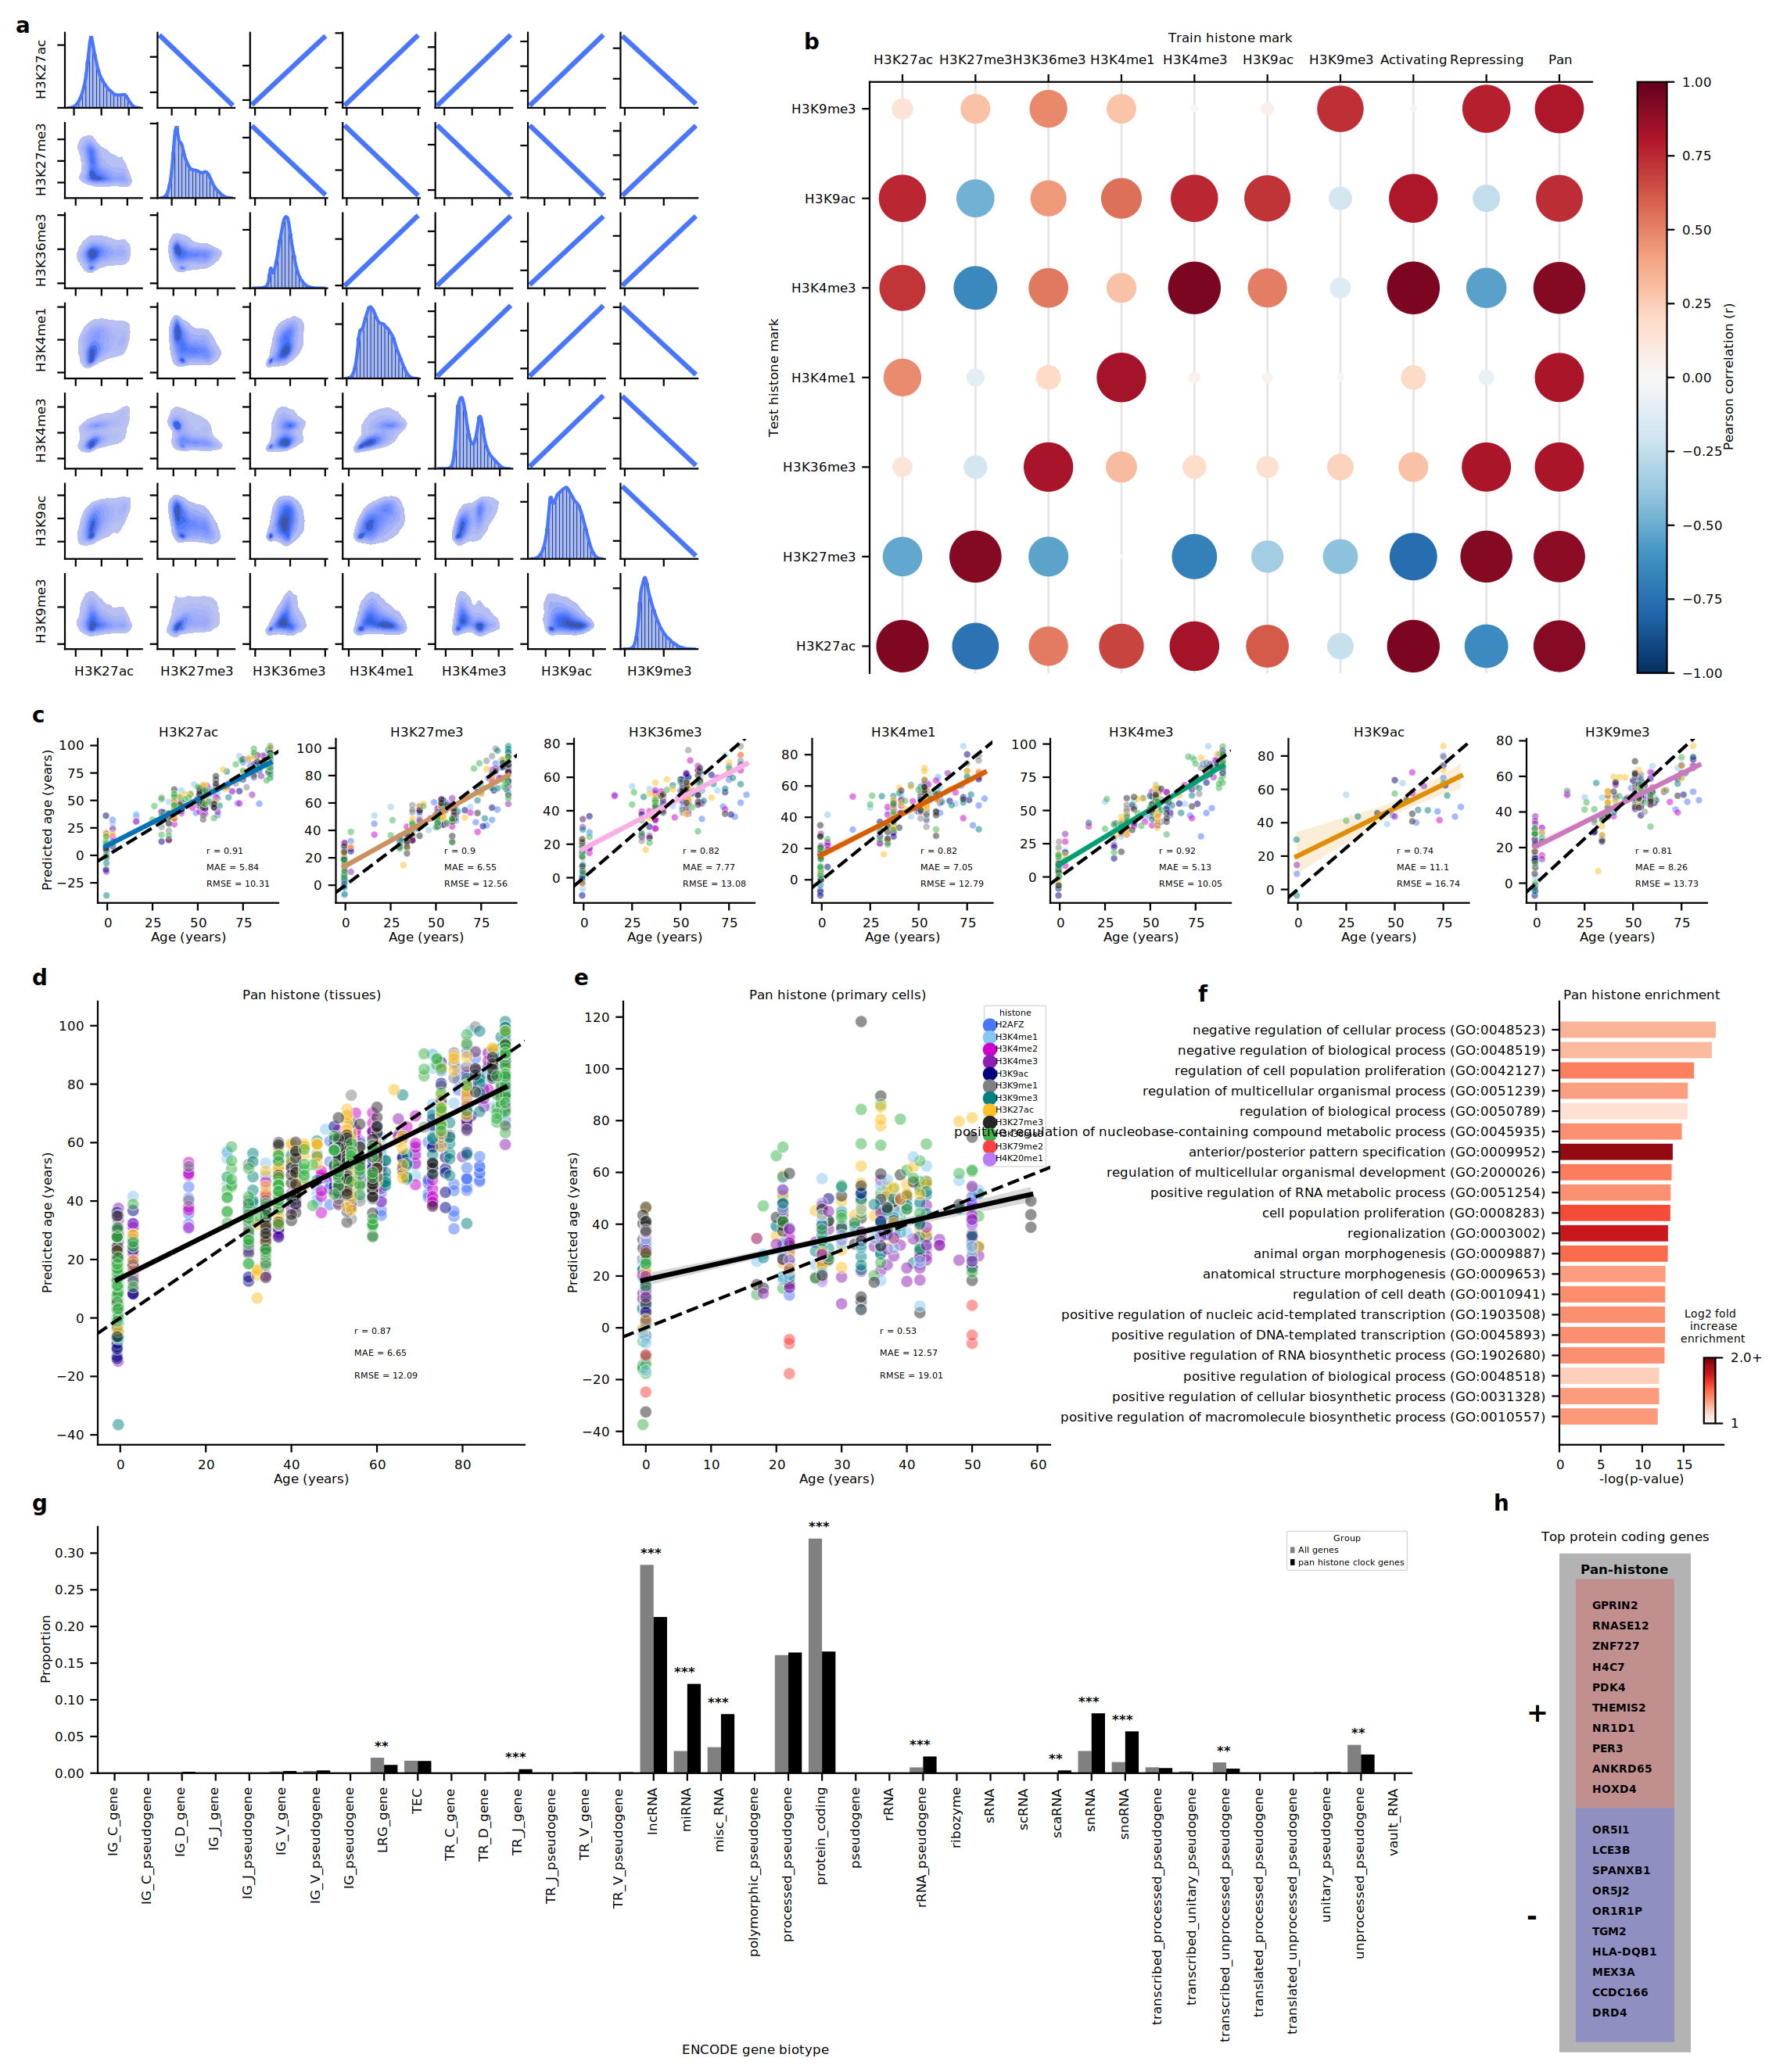

In [148]:
# Function to get axis location
def get_axis_location(axis_lim, d=0.5):
    loc = (axis_lim[1] - axis_lim[0]) * d + axis_lim[0]
    return loc

# Define figure dimensions based on the number of rows and columns
nrows = 14
ncols = 14
fig_height = nrows * 0.75
fig_width = ncols * 0.75

# Initialize the figure and grid spec
fig = plt.figure(figsize=(fig_width, fig_height))
gs = GridSpec(nrows=nrows, ncols=ncols)

# Add figure texts
fig.text(0.15, 0.91, 'a', size=10, weight="bold")
fig.text(0.63, 0.9, 'b', size=10, weight="bold")
fig.text(0.16, 0.49, 'c', size=10, weight="bold")
fig.text(0.16, 0.33, 'd', size=10, weight="bold")
fig.text(0.49, 0.33, 'e', size=10, weight="bold")
fig.text(0.87, 0.32, 'f', size=10, weight="bold")
fig.text(0.16, 0.01, 'g', size=10, weight="bold")
fig.text(1.05, 0.01, 'h', size=10, weight="bold")

# Attempt to load data, otherwise compute the spearman coefficients
try:
    df_spearman_rs = pd.read_pickle('../results/df_spearman_rs.pkl')
except:
    rs = []
    for i, histone in zip(range(len(np.unique(adata_genes.obs.histone))), np.unique(adata_genes.obs.histone)):
        rs_histone = []
        p_values_histone = []
        for i in range(adata_genes.X.shape[1]):
            r, p_value = spearmanr(adata_genes.X[adata_genes.obs.histone == histone][:,i], adata_genes.obs[adata_genes.obs.histone == histone].age)
            rs_histone += [r]
        rs += [rs_histone]
    df_spearman_rs = pd.DataFrame(np.array(rs).T, columns = np.unique(adata_genes.obs.histone), index=adata_genes.var_names)
# Plot the distributions and relations of the spearman coefficients
for i, histone1 in enumerate(np.unique(df_spearman_rs.columns)):
    for j, histone2 in enumerate(np.unique(df_spearman_rs.columns)):
        ax = fig.add_subplot(gs[i, j])
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        if i == j:
            sns.histplot(data=df_spearman_rs, x=histone1, kde=True, bins=20, ax=ax)
        elif i > j:
            sns.kdeplot(data=df_spearman_rs, x=histone2, y=histone1, fill=True, ax=ax)
        elif i < j:
            sns.regplot(data=df_spearman_rs, x=histone2, y=histone1, scatter=False, ax=ax)
        if i == 6:
            ax.set_xlabel(histone2)
        else:
            ax.set_xlabel(None)
        if j == 0:
            ax.set_ylabel(histone1)
        else:
            ax.set_ylabel(None)  
        ax.xaxis.set_ticklabels([])
        ax.yaxis.set_ticklabels([])

# Generate data frames for histone train/test combinations
df_list = []
for train_histone in np.unique(adata_genes_pan_histone.obs.histone):
    for test_histone in np.unique(adata_genes_across_histones.obs.histone):
        filters = (adata_genes_across_histones.obs['histone'] == test_histone)
        y_hat = adata_genes_across_histones[filters].obsm[train_histone + '_cv_test_df'].sum(axis=1)
        y = adata_genes_across_histones[filters].obs.age
        r = pearsonr(y, y_hat)[0]
        mae = np.median(np.abs(y-y_hat))
        df_list += [[train_histone, test_histone, r, mae]]
for test_histone in np.unique(adata_genes_across_activating_histone_group.obs.histone):
    filters = (adata_genes_across_activating_histone_group.obs['histone'] == test_histone)
    y_hat = adata_genes_across_activating_histone_group[filters].obsm['cv_test_df'].sum(axis=1)
    y = adata_genes_across_activating_histone_group[filters].obs.age
    r = pearsonr(y, y_hat)[0]
    mae = np.median(np.abs(y-y_hat))
    df_list += [['Activating', test_histone, r, mae]]
for test_histone in np.unique(adata_genes_across_repressing_histone_group.obs.histone):
    filters = (adata_genes_across_repressing_histone_group.obs['histone'] == test_histone)
    y_hat = adata_genes_across_repressing_histone_group[filters].obsm['cv_test_df'].sum(axis=1)
    y = adata_genes_across_repressing_histone_group[filters].obs.age
    r = pearsonr(y, y_hat)[0]
    mae = np.median(np.abs(y-y_hat))
    df_list += [['Repressing', test_histone, r, mae]]
for test_histone in np.unique(adata_genes_pan_histone.obs.histone):
    filters = (adata_genes_pan_histone.obs['histone'] == test_histone)
    y_hat = adata_genes_pan_histone[filters].obsm['cv_test_df'].sum(axis=1)
    y = adata_genes_pan_histone[filters].obs.age
    r = pearsonr(y, y_hat)[0]
    mae = np.median(np.abs(y-y_hat))
    df_list += [['Pan', test_histone, r, mae]]
    
# Convert the list to a pandas DataFrame
df = pd.DataFrame(df_list, columns=['train_histone', 'test_histone', 'corr', 'mae'])

# Add scatter plot of training vs testing histone marks
ax = fig.add_axes(rect=[0.67, 0.52, 0.55, 0.36])
            
axis = ax.scatter(df["train_histone"], df["test_histone"], c=df["corr"], s=np.abs(df["corr"])*600)
ax.set_ylabel("Test histone mark")
ax.set_xlabel("Train histone mark", labelpad=6)
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.xaxis.grid(color='grey', linestyle='-', linewidth=1, alpha=0.2)
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top') 
axis.set_clim(-1, 1)
cbar = plt.colorbar(axis, ax=ax, label="Pearson correlation (r)")

# Plot the relationship between predicted and actual age for various histone types
for i, histone in enumerate(np.unique(adata_genes_pan_histone.obs.histone)):
    ax = fig.add_axes(rect=[0.2+0.145*i, 0.38, 0.11, 0.1])
    ax.set_title(histone)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    adata = adata_genes_pan_histone[adata_genes_pan_histone.obs.histone == histone]
    y = adata.obsm['cv_test_df'].sum(axis=1)
    x = adata.obs['age']
    corr = round(pearsonr(x,y)[0],2)
    mae = round(np.median(np.abs(x-y)),2)
    rmse = round(np.sqrt(np.mean(np.abs(x-y)**2)),2)
    sns.regplot(x=x, y=y, scatter=False, color=histone_palette[histone], ax = ax)
    for fold in range(adata.obsm['cv_test_df'].shape[1]):
        y = adata.obsm['cv_test_df'].iloc[:,fold]
        sns.scatterplot(x=x, y=y, alpha=0.5, s=10, legend=False, ax = ax)
    x_legend_loc = 0.6
    ax.text(get_axis_location(ax.get_xlim(), x_legend_loc), get_axis_location(ax.get_ylim(), 0.3), 'r = ' + '{}'.format(corr))
    ax.text(get_axis_location(ax.get_xlim(), x_legend_loc), get_axis_location(ax.get_ylim(), 0.2), 'MAE = ' + '{}'.format(mae))
    ax.text(get_axis_location(ax.get_xlim(), x_legend_loc), get_axis_location(ax.get_ylim(), 0.1), 'RMSE = ' + '{}'.format(rmse))
    if i == 0:
        ax.set_ylabel('Predicted age (years)')
    else:
        ax.set_ylabel(None)
    ax.set_xlabel('Age (years)')
    ax.autoscale(False)
    ax.plot([-20, 120], [-20, 120], linestyle='dashed', color='black')
    
# Plot the Pan histone for tissues
ax = fig.add_axes(rect=[0.2, 0.05, 0.26, 0.27])
ax.set_title('Pan histone (tissues)')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
y = adata_genes_pan_histone.obsm['cv_test_df'].sum(axis=1)
x = adata_genes_pan_histone.obs['age']
corr = round(pearsonr(x,y)[0],2)
mae = round(np.median(np.abs(x-y)),2)
rmse = round(np.sqrt(np.mean(np.abs(x-y)**2)),2)
sns.regplot(x=x, y=y, scatter=False, color='black', ax = ax)
for fold in range(adata.obsm['cv_test_df'].shape[1]):
    y = adata_genes_pan_histone.obsm['cv_test_df'].iloc[:,fold]
    sns.scatterplot(x=x, y=y, alpha=0.5, s=30, legend=False, ax=ax)
x_legend_loc = 0.6
ax.text(get_axis_location(ax.get_xlim(), x_legend_loc), get_axis_location(ax.get_ylim(), 0.25), 'r = ' + '{}'.format(corr))
ax.text(get_axis_location(ax.get_xlim(), x_legend_loc), get_axis_location(ax.get_ylim(), 0.2), 'MAE = ' + '{}'.format(mae))
ax.text(get_axis_location(ax.get_xlim(), x_legend_loc), get_axis_location(ax.get_ylim(), 0.15), 'RMSE = ' + '{}'.format(rmse))
ax.set_ylabel('Predicted age (years)')
ax.set_xlabel('Age (years)')
ax.autoscale(False)
ax.plot([-20, 120], [-20, 120], linestyle='dashed', color='black')

# Plot the Pan histone for primary cells
ax = fig.add_axes(rect=[0.52, 0.05, 0.26, 0.27])
ax.set_title('Pan histone (primary cells)')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
feature_selector_path = '../results/models/pan_histone_feature_selector.pkl'
feature_selector = joblib.load(feature_selector_path)
dim_reduction_path = '../results/models/pan_histone_dim_reduction.pkl'
dim_reduction = joblib.load(dim_reduction_path)
model_path = '../results/models/pan_histone_model.pkl'
model = joblib.load(model_path)
y_hat = model.predict(dim_reduction.transform(adata_genes_primary_cells_untreated.X[:, (np.abs(feature_selector.coef_) > 0)]))
y = adata_genes_primary_cells_untreated.obs['age']
adata_genes_primary_cells_untreated.obs['pred_age'] = y_hat
corr = round(pearsonr(y_hat,y)[0],2)
mae = round(np.median(np.abs(y_hat-y)),2)
rmse = round(np.sqrt(np.mean(np.abs(y_hat-y)**2)),2)
sns.regplot(x=y, y=y_hat, scatter=False, color='black', ax = ax)
sns.scatterplot(data=adata_genes_primary_cells_untreated.obs, x='age', y='pred_age', hue='histone', alpha=0.5, s=30, legend=True, ax = ax)
x_legend_loc = 0.6
ax.text(get_axis_location(ax.get_xlim(), x_legend_loc), get_axis_location(ax.get_ylim(), 0.25), 'r = ' + '{}'.format(corr))
ax.text(get_axis_location(ax.get_xlim(), x_legend_loc), get_axis_location(ax.get_ylim(), 0.2), 'MAE = ' + '{}'.format(mae))
ax.text(get_axis_location(ax.get_xlim(), x_legend_loc), get_axis_location(ax.get_ylim(), 0.15), 'RMSE = ' + '{}'.format(rmse))
ax.set_ylabel('Predicted age (years)')
ax.set_xlabel('Age (years)')
ax.autoscale(False)
ax.plot([-20, 120], [-20, 120], linestyle='dashed', color='black')

# Plot the overrepresentation for pan_histone
ax = fig.add_axes(rect=[1.09, 0.05, 0.1, 0.27])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
enrichment_df = get_panther_overrepresentation_df('pan_histone', adata_genes_across_histones, top_n=20)
y_pos = np.arange(20)
cmap_red = mpl.cm.get_cmap('Reds')
cmap_blue = mpl.cm.get_cmap('Blues')
colors = [cmap_red(np.log2(fold)/np.log2(4)) if fold>1 else cmap_blue(np.log2(1/(fold+0.0001))/np.log2(4)) for fold in enrichment_df['fold_enrichment'].tolist()]
ax.barh(y_pos, enrichment_df['negative_log_p_value'], color=colors, align='center') #xerr=error
ax.set_yticks(y_pos, labels=enrichment_df['go_term'])
ax.set_xlabel('-log(p-value)')
ax.set_title('Pan histone enrichment')
ax.invert_yaxis()  # labels read top-to-bottom

ax_color = fig.add_axes(rect=[1.178, 0.063, 0.007, 0.04])
ax_color.set_title('Log2 fold \n increase \n enrichment \n', fontsize=5)
mpl.colorbar.ColorbarBase(ax=ax_color, cmap=cmap_red, orientation="vertical")
ax_color.set_yticks([0,1], labels=[1, str(round(np.log2(4),1)) + '+'])

ax = fig.add_axes(rect=[0.2, -0.15, 0.8, 0.15])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

control_df = adata_genes.var.groupby(by='gene_biotype').count()/adata_genes.var.shape[0]
control_df = control_df.iloc[:,0].reset_index()
control_df.columns = ['gene_biotype', 'percent']
control_df['Group'] = 'All genes'

histone_df = get_gene_weights('pan_histone', adata_genes).groupby(by='gene_biotype').count()/get_gene_weights('pan_histone', adata_genes).shape[0]
histone_df = histone_df.iloc[:,0].reset_index()
histone_df.columns = ['gene_biotype', 'percent']
histone_df['Group'] = 'pan histone' + ' clock genes'

plot_df = pd.concat([control_df, histone_df])
sns.barplot(data=plot_df, x="gene_biotype", y="percent", hue='Group', palette=['gray', 'black'], ax=ax)
ax.tick_params(axis='x', rotation=90)
ax.set_ylabel('Proportion')
if i != 6:
    ax.set_xticks([])
    ax.set_xlabel('')
else:
    ax.set_xlabel('ENCODE gene biotype')

for gene_biotype in np.unique(adata_genes.var.gene_biotype):

    a = np.sum(adata_genes.var.gene_biotype == gene_biotype)
    b = np.sum(adata_genes.var.gene_biotype != gene_biotype)
    c = np.sum(get_gene_weights('pan_histone', adata_genes).gene_biotype == gene_biotype)
    d = np.sum(get_gene_weights('pan_histone', adata_genes).gene_biotype != gene_biotype)
    fisher_exact_test_df = pd.DataFrame([[a, b],[c, d]], columns=['gene_biotype_of_interest', 'other'], index=['all_genes', 'histone'])

    p_value = fisher_exact(fisher_exact_test_df)[1]

    gene_biotype_index = np.where(np.unique(adata_genes.var.gene_biotype) == gene_biotype)[0][0]
    x_pos = ax.containers[0][gene_biotype_index].get_xy()[0]
    if np.mean(adata_genes.var.gene_biotype == gene_biotype) > np.mean(get_gene_weights('pan_histone', adata_genes).gene_biotype == gene_biotype):
        y_pos = np.mean(adata_genes.var.gene_biotype == gene_biotype)
    else:
        y_pos = np.mean(get_gene_weights('pan_histone', adata_genes).gene_biotype == gene_biotype)

    if p_value < 0.0001/len(np.unique(adata_genes.var.gene_biotype)): #p-value with Bonferroni correction for multiple tests
        ax.text(x_pos, y_pos+0.01, '***', size=6, weight="bold")
    elif p_value < 0.001/len(np.unique(adata_genes.var.gene_biotype)):
        ax.text(x_pos+0.12, y_pos+0.01, '**', size=6, weight="bold")
    elif p_value < 0.01/len(np.unique(adata_genes.var.gene_biotype)):
        ax.text(x_pos+0.22, y_pos+0.01, '*', size=6, weight="bold")
        
        
ax = fig.add_axes(rect=[1.08, -0.32, 0.1, 0.31])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.axis('off')

rect=mpatches.Rectangle((0.1,0.0),0.8,0.98, 
                        fill=True,
                        color='black',
                        alpha=0.3,
                        linewidth=0)
ax.add_patch(rect)
rect=mpatches.Rectangle((0.2,0.48),0.6,0.45, 
                        fill=True,
                        color='red',
                        alpha=0.2,
                        linewidth=0)
upregulated = get_gene_weights('pan_histone', adata_genes, protein_coding=True).sort_values(by='gene_weight', ascending=False).symbol.dropna()[0:10].tolist()
for i in range(len(upregulated)):
    ax.text(0.3, 0.87-i*0.04, upregulated[i], size=5, weight="bold")
ax.add_patch(rect)
rect=mpatches.Rectangle((0.2,0.02),0.6,0.46, 
                        fill=True,
                        color='blue',
                        alpha=0.2,
                        linewidth=0)
ax.add_patch(rect)
downregulated = get_gene_weights('pan_histone', adata_genes, protein_coding=True).sort_values(by='gene_weight', ascending=True).symbol.dropna()[0:10].tolist()
for i in range(len(downregulated)):
    ax.text(0.3, 0.43-i*0.04, downregulated[i], size=5, weight="bold")
ax.text(0.23, 0.94, 'Pan-histone', size=6, weight="bold")
ax.text(-0.1, 0.65, '+', size=12, weight="bold")
ax.text(-0.1, 0.25, '-', size=12, weight="bold")
ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.set_title('Top protein coding genes', size=6)

plt.show()

# Saving the figure as a PDF file
fig.savefig("../figures/figure4.pdf", bbox_inches='tight')

# Returning the figure object
fig

## Supplementary Figure 4

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/numpy/lib/function_base.py:2829: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/numpy/lib/function_base.py:2830: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


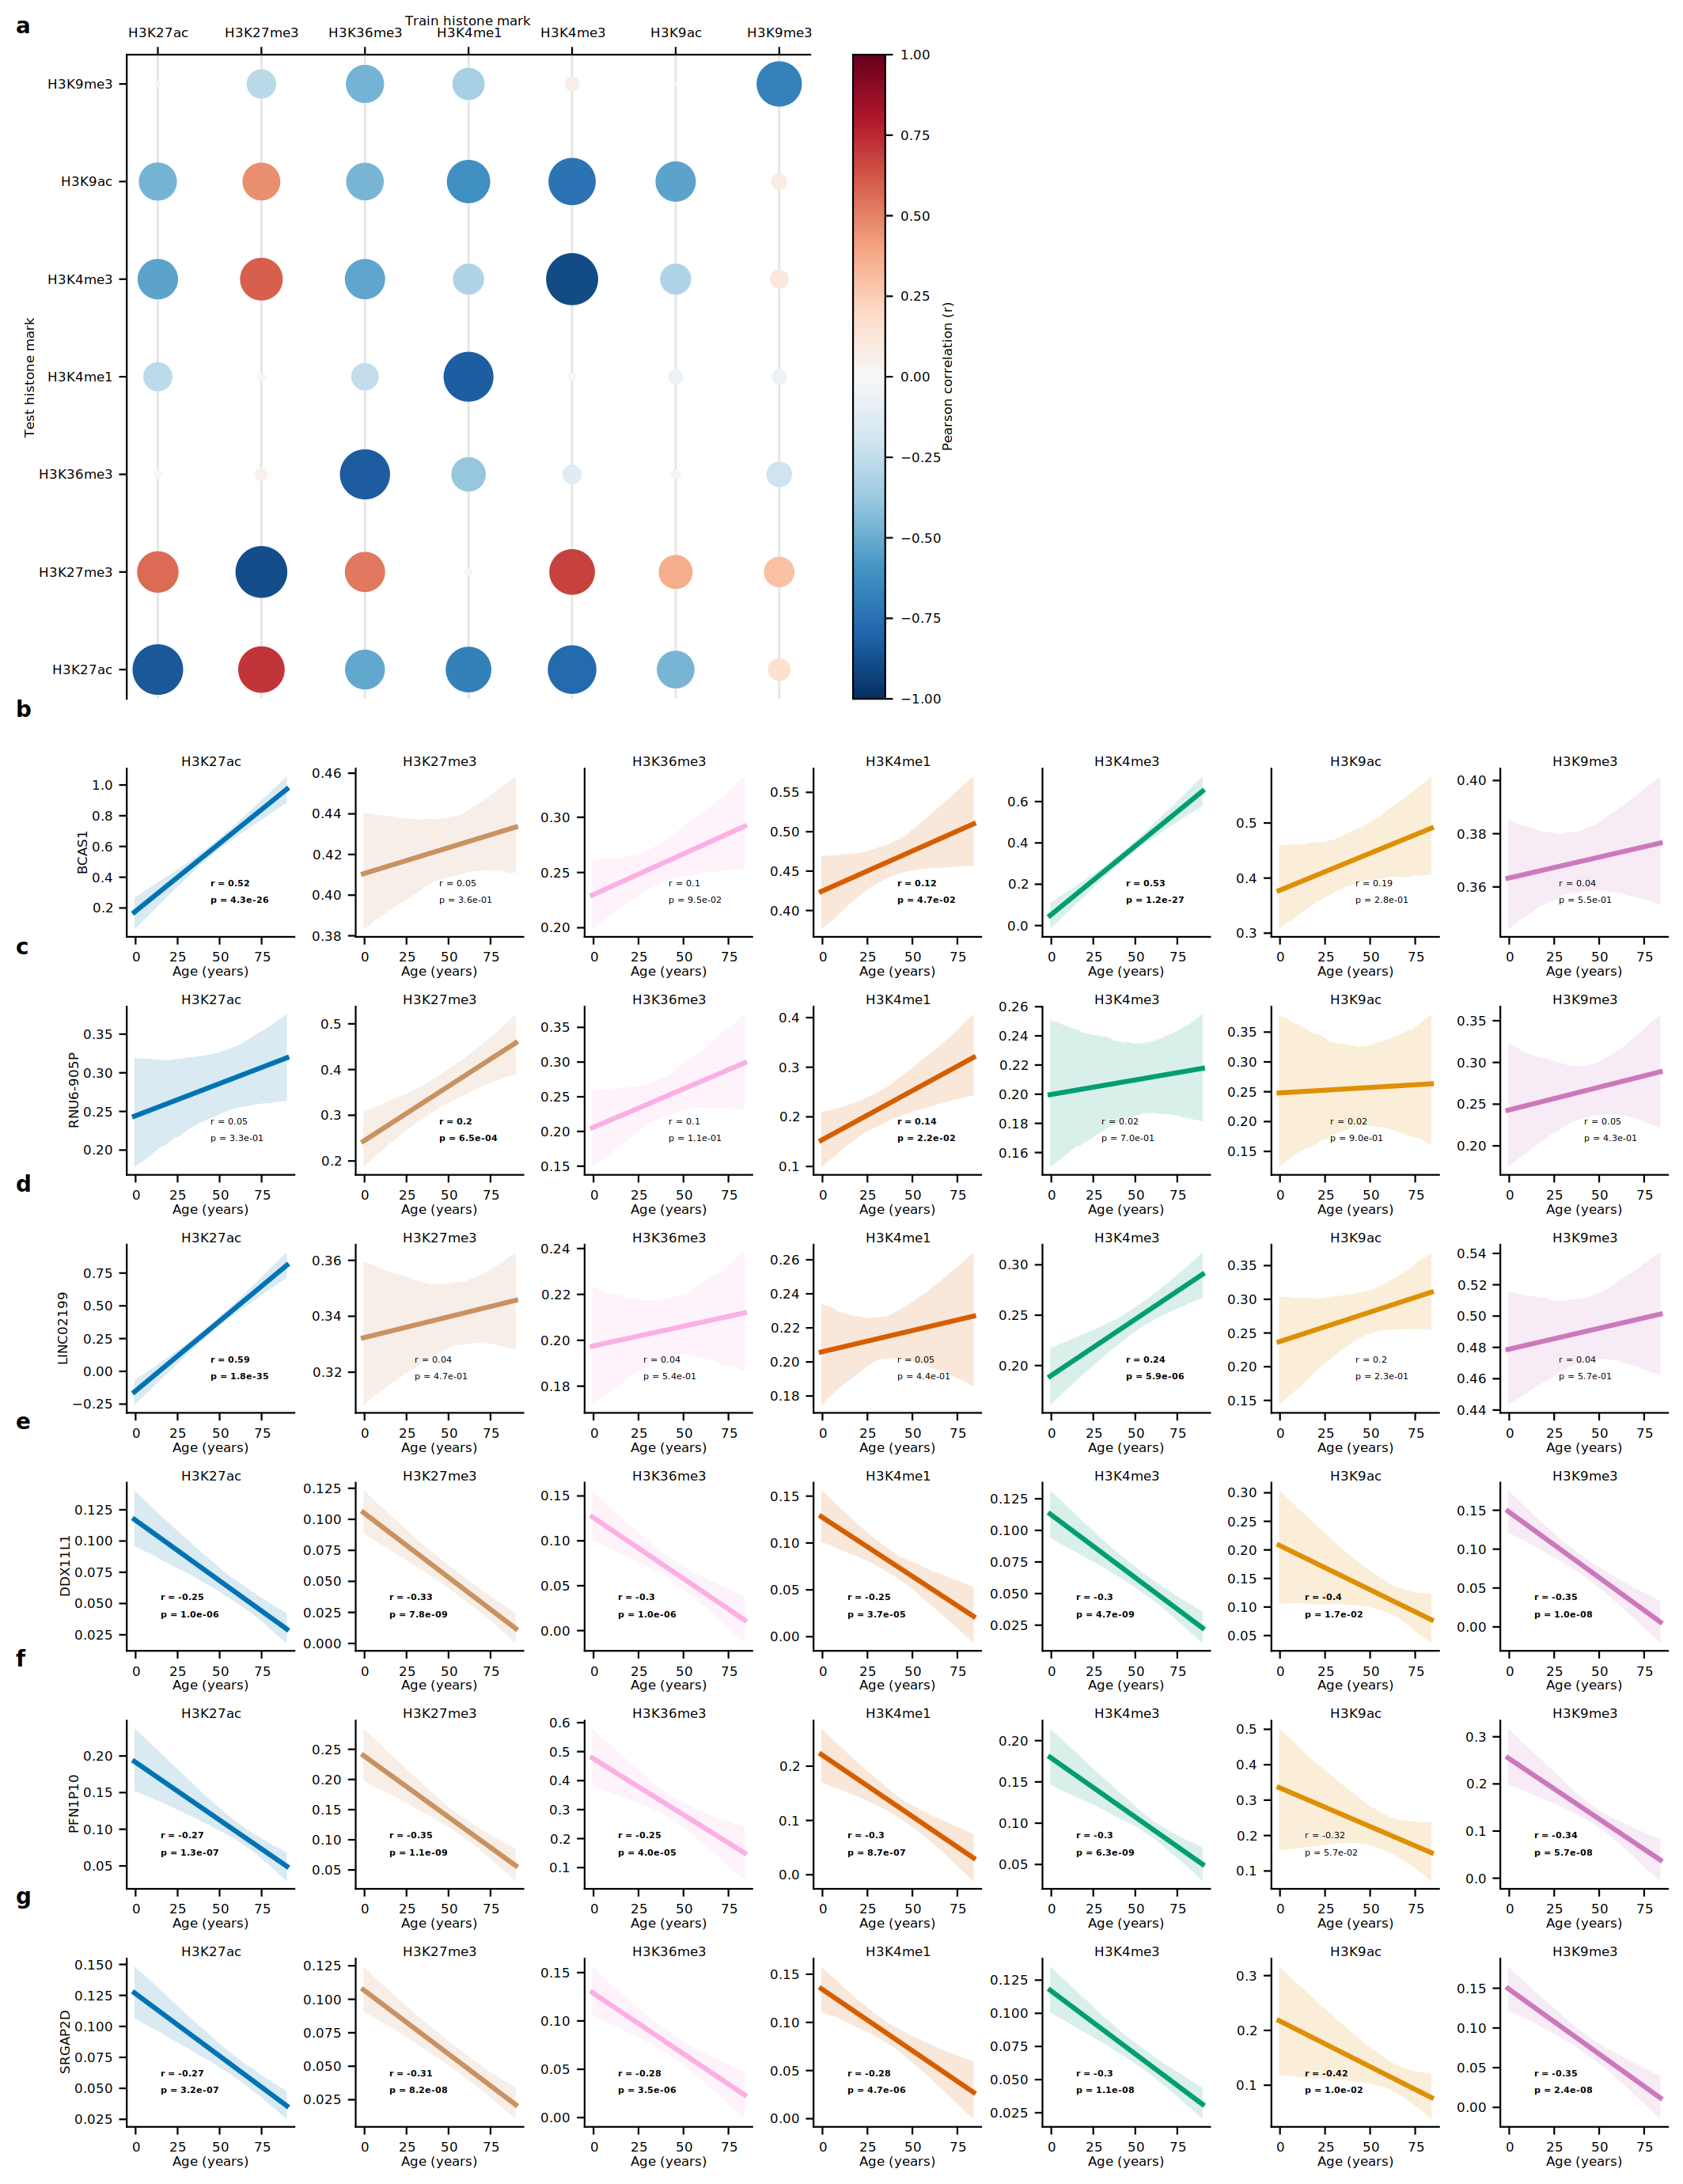

In [138]:
# Setting the number of rows and columns
nrows = 13
ncols = 7

# Defining figure height and width
fig_height = nrows * 1.5
fig_width = ncols * 1.5

# Creating the figure
fig = plt.figure(figsize=(fig_width, fig_height))
gs = GridSpec(nrows=nrows, ncols=ncols)

# Adding text labels 'a' to 'g' to the figure
fig.text(0, (nrows - 0) / nrows - 0.01, 'a', size=10, weight="bold")
fig.text(0, (nrows - 3 - 0.01) / nrows, 'b', size=10, weight="bold")
fig.text(0, (nrows - 4 - 0.01) / nrows, 'c', size=10, weight="bold")
fig.text(0, (nrows - 5 - 0.01) / nrows, 'd', size=10, weight="bold")
fig.text(0, (nrows - 6 - 0.01) / nrows, 'e', size=10, weight="bold")
fig.text(0, (nrows - 7 - 0.01) / nrows, 'f', size=10, weight="bold")
fig.text(0, (nrows - 8 - 0.01) / nrows, 'g', size=10, weight="bold")

# Collecting data for correlation and mean absolute error
df_list = []
for train_histone in np.unique(adata_genes_across_histones_flipped.obs.histone):
    for test_histone in np.unique(adata_genes_across_histones_flipped.obs.histone):
        filters = (adata_genes_across_histones_flipped.obs['histone'] == test_histone)
        y_hat = adata_genes_across_histones_flipped[filters].obsm[train_histone + '_cv_test_df'].sum(axis=1)
        y = adata_genes_across_histones_flipped[filters].obs.age
        r = pearsonr(y, y_hat)[0]
        mae = np.median(np.abs(y - y_hat))
        df_list += [[train_histone, test_histone, r, mae]]

# Creating a DataFrame from the collected data
df = pd.DataFrame(df_list, columns=['train_histone', 'test_histone', 'corr', 'mae'])

# Adding a scatter plot to visualize correlations
ax = fig.add_subplot(gs[0:3, 0:4])
axis = ax.scatter(df["train_histone"], df["test_histone"], c=df["corr"], s=np.abs(df["corr"]) * 600)
ax.set_ylabel("Test histone mark")
ax.set_xlabel("Train histone mark")
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.xaxis.grid(color='grey', linestyle='-', linewidth=1, alpha=0.2)
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')
axis.set_clim(-1, 1)
plt.colorbar(axis, ax=ax, label="Pearson correlation (r)")

# Calculating correlations for histones
all_corrs = np.array([0] * 62241)
for histone in np.unique(adata_genes.obs.histone):
    adata_histone = adata_genes[adata_genes.obs.histone == histone]
    corrs = []
    for i in range(62241 // 5000 + 1):
        corrs += np.corrcoef(x=adata_histone[:, adata_histone.var_names[i * 5000:(i + 1) * 5000]].X.T, y=adata_histone.obs.age)[0:-1, -1].tolist()
    corrs1 = np.array(corrs) > 0.01
    corrs2 = np.array(corrs) < -0.25
    corrs = np.array(corrs1).astype(int) - np.array(corrs2).astype(int)
    all_corrs += corrs
positive_corrs = all_corrs == 7
negative_corrs = all_corrs == -7

# Plotting additional subplots based on correlations
for j, gene in enumerate(adata_genes.var[positive_corrs].gene_name.dropna().tolist()[4:7] + adata_genes.var[negative_corrs].gene_name.dropna()[[0, 3, 5]].tolist()):
    for i, histone in enumerate(np.unique(adata_genes.obs.histone)):
        ax = fig.add_subplot(gs[3 + j, i])
        ax.set_title(histone)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        adata = adata_genes[adata_genes.obs.histone == histone]
        y = adata[:, adata.var.gene_name == gene].X.flatten()
        x = adata.obs['age']
        corr = round(pearsonr(x, y)[0], 2)
        p_value = pearsonr(x, y)[1]
        sns.regplot(x=x, y=y, scatter=False, color=histone_palette[histone], ax=ax)
        # Setting legend position based on correlation value
        x_legend_loc = 0.6
        if p_value < 0.05:
            weight = 'bold'
        else:
            weight = None
        if corr < -0.05:
            x_legend_loc = 0.2
        elif corr > -0.05 and corr < 0.05:
            x_legend_loc = 0.35
        else:
            x_legend_loc = 0.5
        ax.text(get_axis_location(ax.get_xlim(), x_legend_loc), get_axis_location(ax.get_ylim(), 0.3), 'r = ' + '{}'.format(corr), weight=weight)
        ax.text(get_axis_location(ax.get_xlim(), x_legend_loc), get_axis_location(ax.get_ylim(), 0.2), 'p = ' + '{:0.1e}'.format(p_value), weight=weight)
        if i == 0:
            ax.set_ylabel(gene)
        else:
            ax.set_ylabel(None)
        ax.set_xlabel('Age (years)')

# Adjusting layout
plt.tight_layout()

# Displaying the plot
plt.show()

# Saving the figure to a file
fig.savefig("../figures/supplementary_figure4.pdf", bbox_inches='tight')

# Return the figure object
fig

## Information for the manuscript